## Automate prompt engineering with DSPy and Haystack
---

In this example, we will take a look at how we can optimize and automate the prompt engineering process using `Haystack` (to create our generative AI pipeline) and `DSPy` (to optimize our prompts and LM weights).

In [1]:
# For each component, it is essential to know the names of the input and the output. There are several components for various steps
# of the generative AI pipeline that are provided out of the box. This includes components for document stores, embedders, prompt
# builders and generators. You can also build your own component.
!pip install -Uq pip
!pip install -Uq haystack
!pip install -Uq sentence-transformers
!pip install -Uq amazon-bedrock-haystack

In [2]:
# import dependencies
import logging
from haystack import Pipeline

# Set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# initialize a haystack pipeline
pipeline = Pipeline()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


In [3]:
# Define the region
AWS_REGION: str = "us-west-2"
BEDROCK_HAIKU_MODELID: str = "anthropic.claude-3-haiku-20240307-v1:0"
SONNET_3_5_MODELID: str = "anthropic.claude-3-5-sonnet-20240620-v1:0"
SONNET_MODELID: str = "anthropic.claude-3-sonnet-20240229-v1:0"
TITAN_TEXT_EMBED_MODELID: str = "amazon.titan-embed-text-v2:0"

In [4]:
import pandas as pd
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset("vblagoje/PubMedQA_instruction")

# Shuffle and select 1000 samples from the 'train' split
train_data = dataset['train'].shuffle(seed=42).select(range(1000))
df = pd.DataFrame(train_data)

# Save as CSV
csv_path = "PubMedQA_instruction.csv"
df.to_csv(csv_path, index=False)

logger.info(f"Dataset saved to {csv_path}")
df.head()

,instruction,context,response,category
0,Do cC and CXC chemokine levels in children wit...,Chemokines are a superfamily of small peptides...,Initial-phase serum levels of chemokines in pa...,closed_qa
1,Are sAH gene variants associated with obesity-...,The SAH gene locus has recently been proposed ...,We confirm recent evidence that the SAH locus ...,closed_qa
2,Do the functional anatomy of gaze-evoked tinni...,To identify neural sites associated with gaze-...,Patients with GET have plastic changes in mult...,closed_qa
3,Does neighborhood fast-food outlet exposure am...,Greater exposures to fast-food outlets and low...,These findings suggest that efforts to improve...,closed_qa
4,Does conditioned pain modulation predict exerc...,Conditioned pain modulation (CPM) is the conce...,"CPM was attenuated in older adults, as measure...",closed_qa


In [5]:
# view the information on the dataset that is loaded
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  1000 non-null   object
 1   context      1000 non-null   object
 2   response     1000 non-null   object
 3   category     1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB


#### Load the `vblagoje/PubMedQA_instruction` dataset in the in-memory document store

In [6]:
import pandas as pd
from haystack.dataclasses import Document
# initialize the embedders and writers as a part of the RAG pipeline
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

# Create an InMemoryDocumentStore
document_store = InMemoryDocumentStore()

# Now, let's add the embedder and writer components to the RAG pipeline.
# The sentence transformer document embedder uses the 'all-mpnet-base-v2' model as default
pipeline.add_component('embedder', SentenceTransformersDocumentEmbedder())
# whenever we use a document writer it writes document to the document store
pipeline.add_component('writer', DocumentWriter(document_store))
# once we have added the embedder and writer components, we can connect them to the RAG pipeline.
pipeline.connect('embedder', 'writer')

🚅 Components
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - embedder.documents -> writer.documents (List[Document])

In [7]:
import pandas as pd
from haystack.dataclasses import Document

# Load the dataset
df = pd.read_csv(csv_path) 

# Prepare documents
documents = []
for _, row in df.iterrows():
    doc = Document(
        content=f"Instruction: {row['instruction']}\nContext: {row['context']}\nResponse: {row['response']}",
        meta={
            "category": row["category"],
            "question": row["instruction"]
        }
    )
    documents.append(doc)

# Run the pipeline with the documents from the DataFrame
pipeline.run({
    "embedder": {
        "documents": documents
    }
})

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

{'writer': {'documents_written': 1000}}

In [12]:
print(f"Added {len(documents)} documents to the document store.")

Added 1000 documents to the document store.


In [9]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator


retriever = InMemoryEmbeddingRetriever(document_store=document_store)
generator = AmazonBedrockGenerator(model=BEDROCK_HAIKU_MODELID)
# initialize the embdder
embedder = SentenceTransformersTextEmbedder()

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

rag_pipeline = Pipeline()
rag_pipeline.add_component('embedder', embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)

rag_pipeline.connect('embedder', 'retriever')
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: AmazonBedrockGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

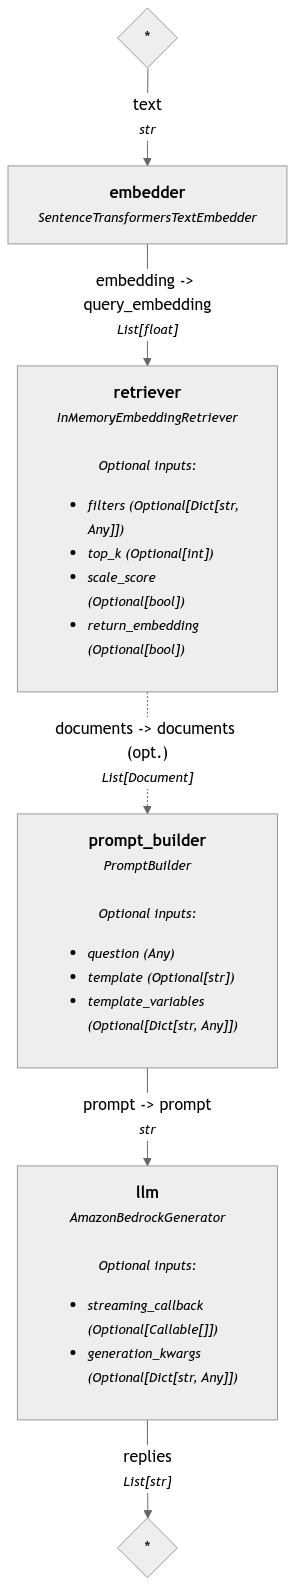

In [10]:
# view the pipeline
rag_pipeline.show()

In [13]:
# run the pipeline and ask a question
question: str = "What is a neurodegenerative disease? Give me examples"
response = rag_pipeline.run({"embedder": {"text": question}, 
                          "prompt_builder": {"question": question}})
print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

A neurodegenerative disease is a condition where the neurons (nerve cells) in the brain and nervous system progressively lose structure or function over time, leading to neurological symptoms and eventual death of these neurons.

Examples of neurodegenerative diseases include:

1. Alzheimer's disease - This is the most common type of dementia, characterized by progressive memory loss, cognitive decline, and changes in behavior and personality.

2. Parkinson's disease - This


### Use DSPy to get more concise answers - wip